## Supplementary figures
## Figure S2: Mean Seasonal Cycle (MSC) comparison of vegetation variables and the first principal component (PC) by pixels


### Estupinan-Suarez, et al. (2021). A Regional Earth System Data Lab for Understanding Ecosystem Dynamics: An Example from Tropical South America. Front. Earth Sci. 9:613395. doi: 10.3389/feart.2021.613395
#### Correspondence to: lestup@bgc-jena.mpg.de, linamaesu@gmail.com
#### GitHub repository: https://github.com/linamaes/Regional_ESDL

This script does the following:
Steps:
- Loads vegetation variables and calculates their MSC
- Loads computed MSC from the first PCA component
- Standardize data for plotting purpose
- Plots vegetation variables MSC at pixel level for different land cover types 


About the notebook
- It is written in Julia 1.3
- "#" comments in the code are intended to explain specific aspects of the coding
- New steps in workflows are introduced with bold headers

April 2021, Max Planck Institute for Biogeochemistry, Jena, Germany

### Activate environment, loading packages

In [1]:
using OnlineStats

In [2]:
using ESDL

In [3]:
using CSV

In [4]:
using Dates

In [5]:
using NPZ

In [6]:
using NetCDF

In [7]:
using Plots

In [8]:
using ESDLPlots

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16165451585482234369\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17849274736689065083\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16165451585482234369\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [9]:
using DelimitedFiles

In [10]:
using MultivariateStats

In [11]:
gr(size=(600,400))
default(fmt = :png)

### Root

In [12]:
pathin1 = "/my_pathin1/.../"
pathin2 = "/my_pathin2/.../"
pathout = "/my_pathout/.../"

"/my_pathin3/.../"

## Load data

### Regional ESDL cube

In [14]:
c = Cube(string(pathin1, "/Cube_2020highColombiaCube_184x120x120.zarr/"))

Collection of ZArray Cube with the following dimensions
Lon                 Axis with 2760 Elements from -82.99622135 to -60.00464665
Lat                 Axis with 3360 Elements from 13.99613735 to -13.99541735
Time                Axis with 782 Elements from 2001-01-05T00:00:00 to 2017-12-31T00:00:00
Variable            Axis with 5 elements: lai fpar gross_primary_productivity evi ndvi 
Total size: 168.85 GB


In [15]:
# set missings 
cmis = map(x-> ismissing(x) ? missing : x==255.0 ? missing : x==65335.0 ? missing : x, c)

Transformed cube Collection of ZArray Cube with the following dimensions
Lon                 Axis with 2760 Elements from -82.99622135 to -60.00464665
Lat                 Axis with 3360 Elements from 13.99613735 to -13.99541735
Time                Axis with 782 Elements from 2001-01-05T00:00:00 to 2017-12-31T00:00:00
Variable            Axis with 5 elements: lai fpar gross_primary_productivity evi ndvi 
Total size: 168.85 GB


In [16]:
# select assessed time period
csub = cmis[time=2001:2014, Variable=["gross_primary_productivity", "ndvi", 
        "evi","fpar"]]

Transformed cube Collection of ZArray Cube with the following dimensions
Lon                 Axis with 2760 Elements from -82.99622135 to -60.00464665
Lat                 Axis with 3360 Elements from 13.99613735 to -13.99541735
Time                Axis with 644 Elements from 2001-01-05T00:00:00 to 2014-12-31T00:00:00
Variable            Axis with 4 elements: gross_primary_productivity ndvi evi fpar 
Total size: 111.24 GB


### Load PCA 1st component (vegetation variables)

In [17]:
cpca = loadCube("pcacom1msc1km2014_mask")

ZArray Cube with the following dimensions
Lon                 Axis with 2760 Elements from -82.99622135 to -60.00464665
Lat                 Axis with 3360 Elements from 13.99613735 to -13.99541735
MSC                 Axis with 46 Elements from -29219.0 to -28859.0
Total size: 1.99 GB


### Load land cover from NetCDF file

In [18]:
clcin = ncread(string(pathin2, "data/LC_ESA/lc_esa2014.nc"),"Land.cover.class.defined.in.LCCS")
clcmis = map(x->x==210.0 ? missing : x, clcin)
clc = CubeMem(CubeAxis[cpca.axes[1], cpca.axes[2]], clcmis)
clcdic = include("lc_legend_abr2.jl");

## Functions

In [19]:
# standardized function
function stdFx(xout, xin)
    xout[:] .= map(x -> (x - OnlineStats.mean(xin))/sqrt(var(xin)), xin)
end

stdFx (generic function with 1 method)

In [20]:
# smoothing function

function getIndex_circ2(x::Vector,i::Integer)
while i<1 || i>length(x)
i = i<1 ? i+length(x) : i-length(x)
end
x[i]
end

function smoothMSC(xin;ns=2)
    any(ismissing,xin) && return(fill!(similar(xin),missing))
    scur = sum(getIndex_circ2(xin,i) for i=1-ns:1+ns)
    afac = 1/(2ns+1)
    xout = zeros(size(xin))
    for i=1:length(xin)
        xout[i]=scur*afac
        scur+=getIndex_circ2(xin,i+ns+1)-getIndex_circ2(xin,i-ns)
    end
    xout
end

smoothMSC (generic function with 1 method)

In [21]:
# function to Normalize data
function norFx(xout, xin)
    xout[:] .= map(x -> (x - minimum(xin))/(maximum(xin) - ninimum(xin)), xin)
end

norFx (generic function with 1 method)

## Define pixels coordinates

In [22]:
# extract longitude and latitude coordinates
lonaxc = collect(csub.cubeaxes[1].values)
lataxc = collect(csub.cubeaxes[2].values);

In [23]:
# create an empty coordinates matrix
pxcor = Array{Float32,2}(undef, 5, 4);

In [24]:
# define pixels location and coordinates
pxcor[:,1] .= [1500, 1830, 1350, 1830, 1801]
pxcor[:,2] .= [1000, 1350, 1830, 2000, 1081]
pxcor[:,3] =  map(x->lonaxc[Int.(x)], (pxcor[:,1]))
pxcor[:,4] =  map(x->lataxc[Int.(x)], (pxcor[:,2]));

# Estimate MSC at pixel level

In [25]:
# start settings
i = 3
nsx = 5
cin = csub

Transformed cube Collection of ZArray Cube with the following dimensions
Lon                 Axis with 2760 Elements from -82.99622135 to -60.00464665
Lat                 Axis with 3360 Elements from 13.99613735 to -13.99541735
Time                Axis with 644 Elements from 2001-01-05T00:00:00 to 2014-12-31T00:00:00
Variable            Axis with 4 elements: gross_primary_productivity ndvi evi fpar 
Total size: 111.24 GB


In [26]:
# get one pixel cube, gap filles and decomposed time series
cpx = cin[lon=pxcor[i,3], lat=pxcor[i,4]]
cfill = gapFillMSC(cpx)
cfft = filterTSFFT(cfill)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In-Memory data cube with the following dimensions
Time                Axis with 644 Elements from 2001-01-05T00:00:00 to 2014-12-31T00:00:00
Scale               Axis with 4 elements: Trend Long-Term Variability Annual Cycle Fast Oscillations 
Variable            Axis with 4 elements: gross_primary_productivity ndvi evi fpar 
Total size: 50.31 KB


In [27]:
# smooth PCA MSC    
pxpca = cpca[lon=pxcor[i,3], lat=pxcor[i,4]]
spxpca = smoothMSC(pxpca[:], ns=nsx);

In [28]:
# fing pixel's land cover
iddic = clc[Int(pxcor[i,1]), Int(pxcor[i,2])]
titlex = clcdic[iddic]

"TreesBrEv-co"

In [29]:
# standardized variables
indims = InDims("Time")
outdims = OutDims("Time")
cstd = mapCube(stdFx, cfill, indims = indims, outdims = outdims)

# get MSC and smooth it
cmsc = getMSC(cstd)
csmo = mapslices(smoothMSC, cmsc, dims="MSC", ns=6)

In-Memory data cube with the following dimensions
MSC                 Axis with 46 Elements from 1900-01-01T00:00:00 to 1900-12-27T00:00:00
Variable            Axis with 4 elements: gross_primary_productivity ndvi evi fpar 
Total size: 920.0 bytes


In [30]:
# get days of year from MSC cube axis
taxin = collect(cmsc.axes[1].values)
tax = map(x->Dates.dayofyear(x), taxin[1:46]);

In [31]:
# get coordinates for title
coordout = string("(Lat. ", round(pxcor[i,4], digits=2) ,"°, Lon. ", round(pxcor[i,3], digits=2),"°)")#,    

"(Lat. -1.25°, Lon. -71.75°)"

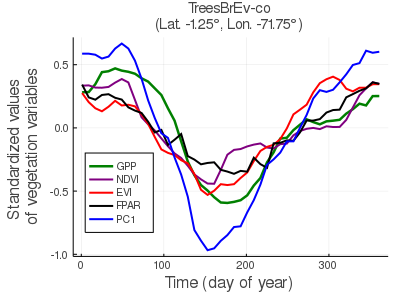

In [32]:
# plot variables
pout = plot(tax, csmo[:,1], label="GPP", lw=2.5,  xlabel="Time (day of year)",  ylabel="Standardized values 
of vegetation variables",
         title = string(titlex, "\n", coordout), titlefontsize = 10, legendfontsize = 7,
        legend =  legend=:bottomleft, size=(400,300), colour=:green)
    plot!(tax, csmo[:,2], lw=2, label="NDVI", colour=:purple)
    plot!(tax, csmo[:,3], lw=2, label="EVI", colour=:red)
    plot!(tax, csmo[:,4], lw=2, label="FPAR", colour=:black)
    plot!(tax, spxpca[:]*-1, lw=2, label="PC1", colour=:blue)

In [33]:
# function for plotting vegetation variables of a single pixel

function pxMSCvarsmo(cin, cpca, clc, clcdic, pxcor, i, smoothMSC; nsx=3)
    
    cpx = cin[lon=pxcor[i,3], lat=pxcor[i,4]]
    cfill = gapFillMSC(cpx)
    
    pxpca = cpca[lon=pxcor[i,3], lat=pxcor[i,4]]
    spxpca = smoothMSC(pxpca[:], ns=nsx)
  
    iddic = clc[Int(pxcor[i,1]), Int(pxcor[i,2])]
    titlex = clcdic[iddic]
    
    indims = InDims("Time")
    outdims = OutDims("Time")
    cstd = mapCube(stdFx, cfill, indims = indims, outdims = outdims)
    cmsc = getMSC(cstd)
    csmo = mapslices(smoothMSC, cmsc, dims="MSC", ns=6)
        
    coordout = string("(Lat. ", round(pxcor[i,4], digits=2) ,"°, Lon. ", round(pxcor[i,3], digits=2),"°)")#,
    
    pout = plot(tax, csmo[:,1], label="GPP", lw=2.5,  xlabel="Time (day of year)",  ylabel="Standardized values 
of vegetation variables",
         title = string(titlex, "\n", coordout), titlefontsize = 10, legendfontsize = 7,
        legend =  legend=:bottomleft, size=(400,300), colour=:green)
    plot!(tax, csmo[:,2], lw=2, label="NDVI", colour=:purple)
    plot!(tax, csmo[:,3], lw=2, label="EVI", colour=:red)
    plot!(tax, csmo[:,4], lw=2, label="FPAR", colour=:black)
    plot!(tax, spxpca[:]*-1, lw=2, label="PC1", colour=:blue)
   
    return pout

end

pxMSCvarsmo (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


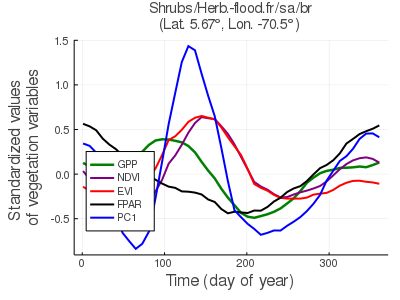

In [34]:
px1 = pxMSCvarsmo(csub, cpca, clc, clcdic, pxcor, 1, smoothMSC)

In [35]:
savefig(px1, string(pathout, "plots/mscpxvarpca/1km/mask/MSCvar&pca2014flooded_mask.png"))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


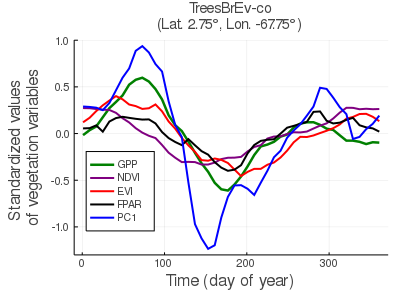

In [36]:
px2 = pxMSCvarsmo(csub, cpca, clc, clcdic, pxcor, 2, smoothMSC, nsx=2)

In [37]:
savefig(px2, string(pathout, "plots/mscpxvarpca/1km/mask/MSCvar&pca2014trees_mask.png"))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


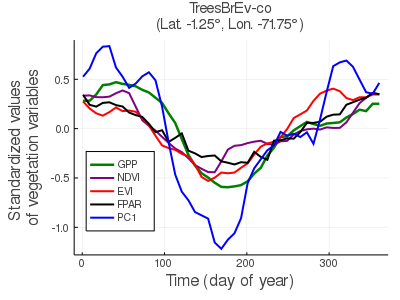

In [38]:
px3 = pxMSCvarsmo(csub, cpca, clc, clcdic, pxcor, 3, smoothMSC, nsx=2)

In [39]:
savefig(px3, string(pathout, "plots/mscpxvarpca/1km/mask/MSCvar&pca2014trees2_mask.png"))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


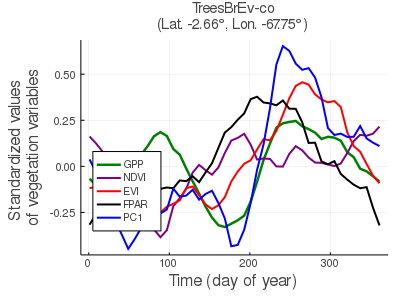

In [40]:
px4 = pxMSCvarsmo(csub, cpca, clc, clcdic, pxcor, 4, smoothMSC)

In [41]:
savefig(px4, string(pathout, "plots/mscpxvarpca/1km/mask/MSCvar&pca2014trees3_mask.png"))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


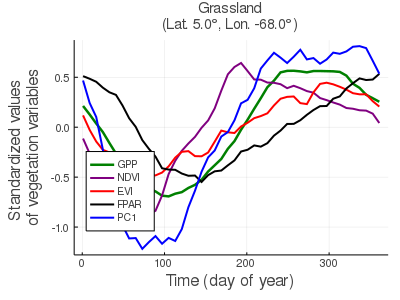

In [42]:
px5 = pxMSCvarsmo(csub, cpca, clc, clcdic, pxcor, 5, smoothMSC)

In [43]:
savefig(px5, string(pathout, "plots/mscpxvarpca/1km/mask/MSCvar&pca2014grassland_mask.png"))